# Starbucks Capstone Challenge

# Project Overview

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem statement

The goal of this project is to **build a model that predicts how a customer would respond to an offer from Starbucks**. 

# Strategy for solving the problem
We can solving this problem using the CRISP-DM process, which involves the following steps:
1. Business Understanding
2. Data Understanding
3. Prepare Data for analysis
4. Data Modeling
5. Evaluate the Results
6. Deploy

We have 3 data sets for the project - Portfolio, Profile and Transcript. After processing each of them, we will combine them to create a commom data which has details of each customer, the detials of each offer made to them and whether the customer responded to the offer.

# Metrics for evaluating the results
For this problem, we will evaluate the ML model's precision and recall to get a better understanding of its performance. The F1-score is a weighted average of the precision and recall.

We will compare the F1-score for multiple ML models such as Logistic regression, RandomForest, NaiveBayes and Gradient Boosting.

We can refine the parameters of the model that has the highest accuracy and F1-score to improve it further

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1 - Data understanding and cleaning

## 1.1 - Portfolio data

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [4]:
portfolio['reward'].unique()

array([10,  0,  5,  3,  2])

In [5]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

##### The Portfolio Dataset analysis 
- It has 6 columns and 10 rows.
- It has no duplicates or missing values.
- There are three types of offers : 'bogo'(Buy One Get One free), 'informational' and 'discount'.
- There are 4 offers included in the dataset that are classified as : “bogo“ , 4 offers classified as : ”discount” and 2 offers classified as : “informational”.
- The 'Difficulty' column name is misleading. It should be renamed as "minspend"
- It also makes sense to rename the 'Id' field as "offer_id" and Replace with simpler ids
- We need to unroll the 'channel' categorical field in to columns for easy processing

In [6]:
def clean_portfolio_data(portfolio):
    '''
    data cleaning the portfolio data
    
    INPUT:
    - the portfolio dataframe to be cleaned
    
    OUTPUT:
    - the cleaned portfolio dataframe
    
    '''
    clean_portfolio = portfolio.copy()

    # renaming 'id' column to offer_id.
    clean_portfolio.rename(columns={'id':'offer_id'},inplace=True)

    # replacing the 'offer_id' by more easy ids
    labels_offer_id = clean_portfolio['offer_id'].astype('category').cat.categories.tolist()
    simpler_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
    clean_portfolio.replace(simpler_offer_id, inplace=True)
    
    # apply one hot encoding to channels column
    clean_portfolio['web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    clean_portfolio['email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    clean_portfolio['mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    clean_portfolio['social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    clean_portfolio['offer_type'] = clean_portfolio['offer_type'].apply(lambda x: 1 if x == 'bogo' else x)
    clean_portfolio['offer_type'] = clean_portfolio['offer_type'].apply(lambda x: 2 if x == 'informational' else x)
    clean_portfolio['offer_type'] = clean_portfolio['offer_type'].apply(lambda x: 3 if x == 'discount' else x)
    
    # drop the channels column
    clean_portfolio.drop(['channels'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    # clean_portfolio = pd.concat([clean_portfolio, offer_column], axis=1, sort=False)
    
    return clean_portfolio

In [7]:
cleaned_portfolio = clean_portfolio_data(portfolio)

In [8]:
cleaned_portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,1,8,0,1,1,1
1,10,10,5,1,5,1,1,1,1
2,0,0,4,2,4,1,1,1,0
3,5,5,7,1,7,1,1,1,0
4,5,20,10,3,1,1,1,0,0
5,3,7,7,3,2,1,1,1,1
6,2,10,10,3,10,1,1,1,1
7,0,0,3,2,6,0,1,1,1
8,5,5,5,1,9,1,1,1,1
9,2,10,7,3,3,1,1,1,0


## 1.2 - Profile data

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
# checking for the column names
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [11]:
# checking for the existence of missing values(NaNs)
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [12]:
# Checking the Gender column
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [13]:
# checking the unique values in the customers ages sorted in descending order
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [14]:
# checking the number of customers who have age > 100
profile['age'][profile['age'] > 100].count()

2180

In [15]:
# checking the data of customers with age > 100
profile[profile['age'] > 100].count()

gender                 5
age                 2180
id                  2180
became_member_on    2180
income                 5
dtype: int64

##### The Profile Dataset analysis
- The dataset has 2175 missing values on each of:  ‘gender’, ’income’ variables.
- The customers ages range from 18 to 118. Most of the people with Age > 100 lots of missing data. These profile can be removed as incomplete
- The column 'became_member_on' is not in easily understandable format. It make sense to convert it to number of days since becoming member.
- Also we'll extract the year the customer become member in to 'membership_year'
- Replace the 'gender' categorical labels with simpler numerical id
    - 1 : M (Male)
    - 2 : F (Female)
    - 3 : O (Others)

In [16]:
def clean_profile_data(profile):
    '''
    cleaning the profile data
    
    INPUT:
    - the profile dataframe to be cleaned
    
    OUTPUT:
    - the cleaned profile dataframe

    '''

    clean_profile = profile.copy()

    # renaming 'id' column to customer_id.
    clean_profile.rename(columns={'id':'customer_id'},inplace=True)

    # replacing the 'gender' categorical labels with coressponding numerical label
    labels_gender = clean_profile['gender'].astype('category').cat.categories.tolist()
    simpler_gender_ids = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
    clean_profile.replace(simpler_gender_ids, inplace=True)

    # age: remove all values above 100
    clean_profile['age'] = profile['age'].apply(lambda x: np.nan if x > 100 else x)
    clean_profile.dropna(inplace=True)

    # changing the datatype of 'became_member_on' column from int to date and put it in the appropriate format
    clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format = '%Y%m%d')
    clean_profile['membership_year'] = clean_profile['became_member_on'].dt.year

    # the number of days since the user is a memeber of starbucks
    clean_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.date
    clean_profile['memberdays'] = clean_profile['memberdays'].dt.days
    
    return clean_profile

In [17]:
cleaned_profile = clean_profile_data(profile)

In [18]:
cleaned_profile.head()

,gender,age,customer_id,became_member_on,income,membership_year,memberdays
1,1.0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,1080
3,1.0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1147
5,2.0,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,795
8,2.0,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,871
12,2.0,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,961


## 1.3 - Transcript data

In [19]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [20]:
# checking for missing values(NaNs)
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [21]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

##### The Transcript Dataset analysis
- The dataset has NO missing values
- The 'Event' and 'Value' fields are categorical columns
- For further processing, we need to extract offer_id from 'value' column into a seperate column
- To predict if a person would respond to an offer, we need to focus on the following 2 event types only;
    1. Offer Viewed
    2. Offer Completed
- Hence we will remove all data related to events 'Offer received' and 'Transaction'

In [22]:
def clean_transcript_data(transcript):
    '''
    cleaning the transcript dataframe
    
    INPUT:
    - the transcript dataframe to be cleaned
    
    OUTPUT:
    - the cleaned transcript dataframe
    
    '''
    clean_transcript = transcript.copy()

    # renaming 'person' column to customer_id.
    clean_transcript.rename(columns={'person':'customer_id'},inplace=True)

    # excluding all events of 'transaction' from our clean_transcript dataset
    clean_transcript = clean_transcript[clean_transcript['event'] != 'transaction']

    # excluding all events of 'offer received' 
    clean_transcript = clean_transcript[clean_transcript['event'] != 'offer received']

    # make events numeric where 1 = Offer_completed and 2 = Offer_viewed
    clean_transcript['event'] = clean_transcript['event'].apply(lambda x: 1 if x == 'offer completed' else 2)

    # extract the offer id from value column
    clean_transcript['offer_id'] = clean_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

    # replacing the 'offer_id' by more easy ids
    labels_offer_id = clean_transcript['offer_id'].astype('category').cat.categories.tolist()
    simpler_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
    clean_transcript.replace(simpler_offer_id, inplace=True)

    return clean_transcript

In [23]:
cleaned_transcript = clean_transcript_data(transcript)

In [24]:
cleaned_transcript

,customer_id,event,value,time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,2,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,9
12651,d1ede868e29245ea91818a903fec04c6,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,6
12652,102e9454054946fda62242d2e176fdce,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,5
12653,02c083884c7d45b39cc68e1314fec56c,2,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,8
12655,be8a5d1981a2458d90b255ddc7e0d174,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,6
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,1,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,2
306506,b895c57e8cd047a8872ce02aa54759d6,1,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,10
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,2,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},714,1
306509,8431c16f8e1d440880db371a68f82dd0,1,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,10


#### Some additional processing can be done on cleaned_transcript to
- extract the reward amount from the value field
- drop the 'value' column since it's data is now available in rewards and offer_id columns

In [25]:
# Iterating over cleaned_transcript dataset and checking 'value' column
# then updating it and using the values to fill in the columns created above
for idx, row in cleaned_transcript.iterrows():
    for k in row['value']:
        # print(k)
        if k == 'reward':
            cleaned_transcript.at[idx, 'reward'] = row['value'][k]
        else:
            cleaned_transcript.at[idx, 'reward'] = 0

In [26]:
cleaned_transcript.drop('value', axis=1, inplace=True)

In [27]:
cleaned_transcript

,customer_id,event,time,offer_id,reward
12650,389bc3fa690240e798340f5a15918d5c,2,0,9,0.0
12651,d1ede868e29245ea91818a903fec04c6,2,0,6,0.0
12652,102e9454054946fda62242d2e176fdce,2,0,5,0.0
12653,02c083884c7d45b39cc68e1314fec56c,2,0,8,0.0
12655,be8a5d1981a2458d90b255ddc7e0d174,2,0,6,0.0
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,1,714,2,3.0
306506,b895c57e8cd047a8872ce02aa54759d6,1,714,10,2.0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,2,714,1,0.0
306509,8431c16f8e1d440880db371a68f82dd0,1,714,10,2.0


### Merging the three datasets into one unified dataset

In [28]:
# merge 'cleaned_transcript' dataset with 'cleaned_portfolio' based on 'offer_id'
common_df = cleaned_transcript.merge(cleaned_portfolio,how='left',on='offer_id')

In [29]:
# join 'common_df' dataset with 'cleaned_profile' on 'customer_id'
common_df = common_df.merge(cleaned_profile,how ='left', on = 'customer_id')

In [30]:
common_df.head()

,customer_id,event,time,offer_id,reward_x,reward_y,difficulty,duration,offer_type,web,email,mobile,social,gender,age,became_member_on,income,membership_year,memberdays
0,389bc3fa690240e798340f5a15918d5c,2,0,9,0.0,5,5,5,1,1,1,1,1,2.0,65.0,2018-02-09,53000.0,2018.0,871.0
1,d1ede868e29245ea91818a903fec04c6,2,0,6,0.0,0,0,3,2,0,1,1,1,3.0,53.0,2017-09-16,52000.0,2017.0,1017.0
2,102e9454054946fda62242d2e176fdce,2,0,5,0.0,10,10,5,1,1,1,1,1,1.0,69.0,2016-08-14,57000.0,2016.0,1415.0
3,02c083884c7d45b39cc68e1314fec56c,2,0,8,0.0,10,10,7,1,0,1,1,1,1.0,20.0,2016-07-11,30000.0,2016.0,1449.0
4,be8a5d1981a2458d90b255ddc7e0d174,2,0,6,0.0,0,0,3,2,0,1,1,1,2.0,39.0,2014-05-27,51000.0,2014.0,2225.0


In [31]:
common_df.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'reward_x', 'reward_y',
       'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile',
       'social', 'gender', 'age', 'became_member_on', 'income',
       'membership_year', 'memberdays'],
      dtype='object')

In [32]:
common_df.shape

(91304, 19)

In [33]:
common_df.isna().sum()

customer_id            0
event                  0
time                   0
offer_id               0
reward_x               0
reward_y               0
difficulty             0
duration               0
offer_type             0
web                    0
email                  0
mobile                 0
social                 0
gender              9028
age                 9028
became_member_on    9028
income              9028
membership_year     9028
memberdays          9028
dtype: int64

In [34]:
common_df.dropna(inplace=True)

# 2 - Data Modeling

#### In this part, we are going to build a machine learning model that predicts whether or not a person will respond to an offer from Starbucks

In [35]:
# Import all the required packages
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score

import matplotlib.pyplot as plt
import seaborn as sns

#### We need to split data into features and target labels 

#### Feature labels:
    - time
    - offer_id
    - reward_x
    - difficulty
    - duration
    - offer_type
    - gender
    - age
    - income
    - membership_year

#### Target labels
- 'event' that will be either:
    - 1 : offer completed
    - 2 : offer viewed
    
#### These features are important for our model to predict if a customer would respond to an offer

In [36]:
# Split the data into features and target label
X = common_df[['time','offer_id','reward_x','difficulty','duration','offer_type','gender','age','income', 'membership_year']]
Y = common_df['event']

In [37]:
# creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [38]:
y_train.value_counts()

2    37401
1    24306
Name: event, dtype: int64

In [39]:
y_test.value_counts()

2    12443
1     8126
Name: event, dtype: int64

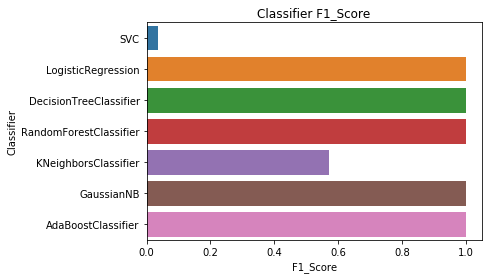

In [40]:
# Let's check out which classifier will work best in our case

classifiers = [ 
                SVC(gamma=2, C=1),
                LogisticRegression(max_iter=1000, random_state=123),
                DecisionTreeClassifier(max_depth=5),
                RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                KNeighborsClassifier(),
                GaussianNB(),
                AdaBoostClassifier()
              ]

# Split the data into features and target label
X = common_df[['time','offer_id','reward_x','difficulty','duration','offer_type','gender','age','income', 'membership_year']]
Y = common_df['event']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

results = pd.DataFrame(columns=["Classifier", "F1_Score"])

acc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = f1_score(y_test, y_pred)
    if name not in acc_dict:
        acc_dict[name] = acc
    else:
        acc_dict[name] += acc

for clf in acc_dict:
    classifier_score = pd.DataFrame([[clf, acc_dict[clf]]], columns=["Classifier", "F1_Score"])
    results = results.append(classifier_score)

plt.xlabel('F1_Score')
plt.title('Classifier F1_Score')

sns.barplot(x='F1_Score', y='Classifier', data=results);



#### Now we can see which of the features contribute most to the customer's buying decision, by using the Feature_importance_ attribute of Random Forest classifier

In [41]:
# Split the data into features and target label
X1 = common_df[['time','offer_id','reward_x','difficulty','duration','offer_type','gender','age','income', 'membership_year']]
Y1 = common_df['event']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, random_state=42)

In [42]:
rfc_best_est = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)

In [43]:
rfc_best_est.fit(X1_train, y1_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [44]:
y1_pred =  rfc_best_est.predict(X1_test)

In [45]:
rfc_best_est.feature_importances_

array([0.0340956 , 0.02768954, 0.75906364, 0.05941459, 0.03667635,
       0.0561347 , 0.00288118, 0.00238294, 0.00788282, 0.01377864])

In [46]:
# Prepare the dataframe of feature importances given to features by best estimator of RandomForestClassifier
feat_imp_df = pd.DataFrame(rfc_best_est.feature_importances_, index=X1_train.columns.tolist(), columns=['feat_imp']).reset_index()
feat_imp_df.rename(columns={'index': 'feature'}, inplace=True)
feat_imp_df['feat_imp_perc'] = np.round((feat_imp_df['feat_imp']/feat_imp_df['feat_imp'].sum())*100,2)
feat_imp_df = feat_imp_df.sort_values(by=['feat_imp_perc'], ascending=False).reset_index(drop=True)
feat_imp_df

,feature,feat_imp,feat_imp_perc
0,reward_x,0.759064,75.91
1,difficulty,0.059415,5.94
2,offer_type,0.056135,5.61
3,duration,0.036676,3.67
4,time,0.034096,3.41
5,offer_id,0.027690,2.77
6,membership_year,0.013779,1.38
7,income,0.007883,0.79
8,gender,0.002881,0.29
9,age,0.002383,0.24


# 3. Evaluation of Results

### It looks like Logistic regression, DecisionTree, NaiveBayes and AdaBoost classifiers are giving similar results

All of these models have an F1 Score of 1.0 for both training and testing. This could be result of over training on the data. But given that the problem we are trying to solve is a binary one - Respond or not to an offer - this is may not be a over-training issue.

**Such high F1-score has eliminated the need for further refinement using GridSearch to find better parameters.**

### We can create a prediction engine based on any of these classifiers to predict if the customer would respond to an offer from Starbucks

# 4. Conclusion

This project helped me analyse the datasets provided by Starbucks and then build a model to predict how a customer would respond to an offer from Starbucks.

As i have been following the CRISP-DM process for all the projects in the course, i knew how to go about the project. 

Hence i began the project by reading the description provided by Udacity (at the beginning of this notebook) multiple times to understand the business and the mechanics of this project.

Then i focussed on the datasets provided. The first question for any dataset in a data science project is, it it good enough  for the problem on hand. Thanks to Udacity and Starbucks, the dataset is of high quality.

Once dataset was analysed, i was ready for preprocessing the data for model building. Most of the work involved handling the categorical values in the data set. Once cleaned up, the 3 distinct set of data was merged to once common data for model building. This step consumed a lot of my time.

Once data was available in right format, i moved to model building. I decided to use multiple classification algorithms to build prediction model and then choose one which gives the highest F1-score.

# 5. Reflection

After spending last few months on learning the data science techniques and tools, i was ready for this project. As such i really enjoyed the project as i was confident.

This project helped me get clear understanding of the end-to-end process involved in data science. 

After completing this work, i feel proud of myself and very thankful to udacity for putting togather such a great content for the course. 